In [32]:
import DataLoading
from torch.utils.data import DataLoader,TensorDataset
import torch
import pandas as pd
import NN_classes
import training_methods
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [33]:
sc = "sc01"
period = "2030"
folder = "../Data/RTS24_AC_12w/"
all_executions = DataLoading.list_executions(folder="../Data/RTS24_AC_12w",per = period,sc=sc)
len(all_executions)
executions = all_executions[0:20]
te_s = 0.3
val_s = 0.4

In [34]:
dfs_in,dfs_out = DataLoading.load_data(folder,executions,period,sc)

input_f_sc01_Network_Existing_Generation_Full_2030.csv
1227
input_f_sc01_Network_Line_In_N_101_N_102_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_101_N_103_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_101_N_105_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_102_N_104_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_102_N_106_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_103_N_109_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_103_N_124_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_104_N_109_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_105_N_110_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_106_N_108_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_106_N_110_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_107_N_108_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_108_N_109_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_108_N_110_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_109_N_111_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_109_N_112

In [35]:
ts_in,ts_out =  DataLoading.split_tr_val_te_by_exec(dfs_in,dfs_out,executions,te_s,val_s,False)

In [36]:
d_ft_in, d_ft_out,maxs = DataLoading.concat_and_normalize_split_by_exec(ts_in,ts_out,executions)

In [37]:
executions = list(dfs_in.keys())
tr_exs = list(ts_in["train"].keys())
te_exs = list(ts_in["test"].keys())
val_exs = list(ts_in["val"].keys())

In [6]:
# train = TensorDataset(d_ft_in['train'].float(), d_ft_out['train'].float())
# validation = TensorDataset(d_ft_in['val'].float(), d_ft_out['val'].float())

# training_loader = DataLoader(train,batch_size=64)
# validation_loader = DataLoader(train,batch_size=64)

In [59]:
folder = "RTS24_AC_12w_split_by_exec_nl"
mt = "all_epochs"


dor = 0
lr = 0.0025
nb_e = 12
nb_hidden = 3
relu_out = True

models = dict()
for nb_hidden in [2,3]: 
    key = nb_hidden
    m_name = f"OE_{nb_hidden}h_{nb_e}e_{lr}lr_{dor}dor"
    #m_name = f"OE_{nb_hidden}h_{nb_e}e_{lr}lr_{dor}dor_{np}np_{relu_out}_ro"
    path = f"trained_models/{folder}/{mt}/model_{m_name}.pth"

    models[key] = NN_classes.create_model(nb_hidden,d_ft_in['train'].shape[1],dropout_ratio= dor)
    models[key].load_state_dict(torch.load(path))
    models[key].eval()



ObjectiveEstimator_ANN_2hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (hidden_layer2): Linear(in_features=35, out_features=5, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (output_layer): Linear(in_features=5, out_features=1, bias=True)
) 0 2 False
ObjectiveEstimator_ANN_3hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=306, bias=True)
  (hidden_layer2): Linear(in_features=306, out_features=76, bias=True)
  (hidden_layer3): Linear(in_features=76, out_features=19, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (output_layer): Linear(in_features=19, out_features=1, bias=True)
) 0 3 False


In [60]:
#Check an execution part of training set

#First, select an execution
execution = tr_exs[0]
#Load the input and output data for this execution
ex_in = torch.nan_to_num(ts_in["train"][execution]/maxs)
ex_out = ts_out["train"][execution]
loss_fn_1 = torch.nn.L1Loss()
loss_fn_2 = torch.nn.MSELoss()

#Make model predictions based on input
predictions = dict()

for k in models:
    print(k)
    m = models[k]
    predictions[k] = m(ex_in.float())

# m = models[0]

2
3


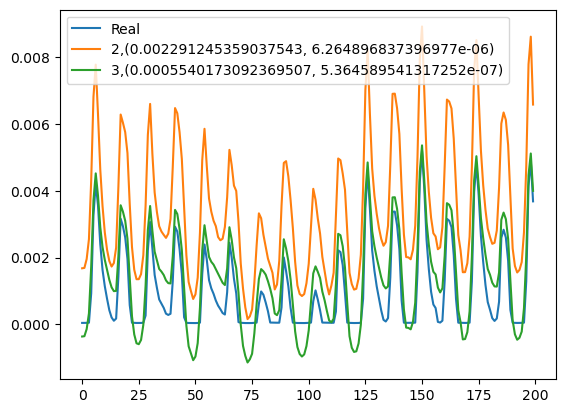

In [61]:
s = 0
e = s+200

plt.plot(ex_out[s:e],label = "Real")
for k in predictions:
    train_losses = (loss_fn_1(predictions[k].squeeze(),ex_out).item(),loss_fn_2(predictions[k].squeeze(),ex_out).item())
    plt.plot(predictions[k].detach()[s:e],label = f"{k},{train_losses}")
plt.legend()


In [14]:
output = predictions[k]
negative_penalization =  torch.nan_to_num(-1*torch.mean(1*(output[output<0])))
negative_penalization

tensor(0., grad_fn=<NanToNumBackward0>)

C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSE losses:


AttributeError: 'int' object has no attribute 'mean'

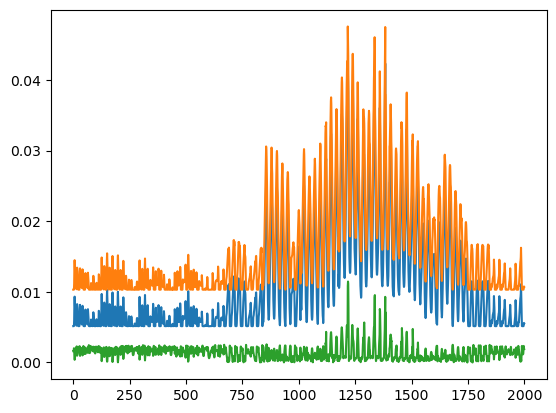

In [29]:
mae_losses = dict()
mse_losses = dict()
mse_losses_torch = dict()
s = 0
e= 2000

for dor in predictions:
    mae_losses[dor] = [abs((predictions[dor][i]-ex_out[i]).item()) for i in range(s,e) ]
    mse_losses[dor] = [((predictions[dor][i]-ex_out[i]).item())**2 for i in range(s,e) ]
    mse_losses_torch[dor] = [loss_fn_2(predictions[dor][i],ex_out[i]).item() for i in range(s,e) ]
    plt.plot(mae_losses[dor],label = dor)
#loss_fn_1(predictions[k][1],ex_out[1])

# plt.legend()
# print("MAE losses:")
# print("dor 0:",np.mean(mae_losses[0]),loss_fn_1(predictions[0][0:end],ex_out[0:end]).item())
# print("dor 0.1:",np.mean(mae_losses[.1]),loss_fn_1(predictions[0.1][0:end],ex_out[0:end]).item())

print("MSE losses:")
for k in predictions:
    print(f"{k}:",np.mean(mse_losses[k]),np.mean(mse_losses_torch[k]),loss_fn_2(predictions[k][s:e].squeeze(),ex_out[s:e]).item())


Train example
Validation example


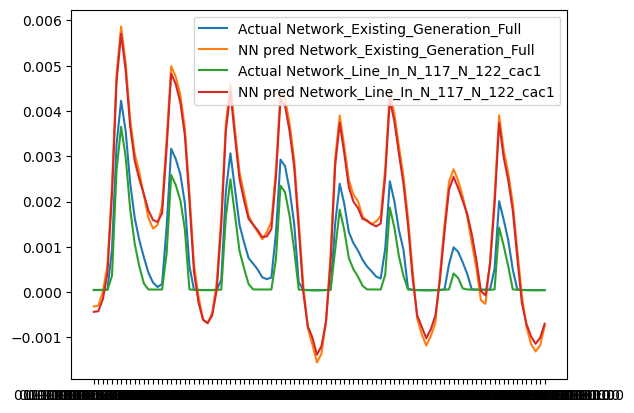

In [137]:
#Compare the results of different executions 
i,j = 0,32
s = 0
e = s+100

for k in [i,j]:
    name = executions[k]
    if name in ts_in["train"].keys():
        ex_in = torch.nan_to_num(ts_in["train"][name]/maxs)
        print("Train example")
    elif name in ts_in["test"].keys(): 
        ex_in = torch.nan_to_num(ts_in["test"][name]/maxs)
        print("Test example")
    elif name in ts_in["val"].keys():
        print("Validation example")
        ex_in = torch.nan_to_num(ts_in["val"][name]/maxs)

        
    predictions[k] = m(ex_in.float())

    plt.plot(dfs_out[executions[k]].sum(axis=1)[s:e],label = f"Actual {executions[k]} ")
    plt.plot(predictions[k].detach()[s:e],label = f"NN pred {executions[k]}")

plt.legend()


In [121]:
ts_in["train"].keys()

dict_keys(['Network_Existing_Generation_Full', 'Network_Line_In_N_101_N_102_cac1', 'Network_Line_In_N_101_N_103_cac1', 'Network_Line_In_N_101_N_105_cac1', 'Network_Line_In_N_102_N_104_cac1', 'Network_Line_In_N_102_N_106_cac1', 'Network_Line_In_N_103_N_109_cac1', 'Network_Line_In_N_103_N_124_cac1', 'Network_Line_In_N_104_N_109_cac1', 'Network_Line_In_N_105_N_110_cac1', 'Network_Line_In_N_106_N_108_cac1', 'Network_Line_In_N_106_N_110_cac1', 'Network_Line_In_N_107_N_108_cac1', 'Network_Line_In_N_108_N_109_cac1', 'Network_Line_In_N_108_N_110_cac1', 'Network_Line_In_N_109_N_111_cac1', 'Network_Line_In_N_109_N_112_cac1'])

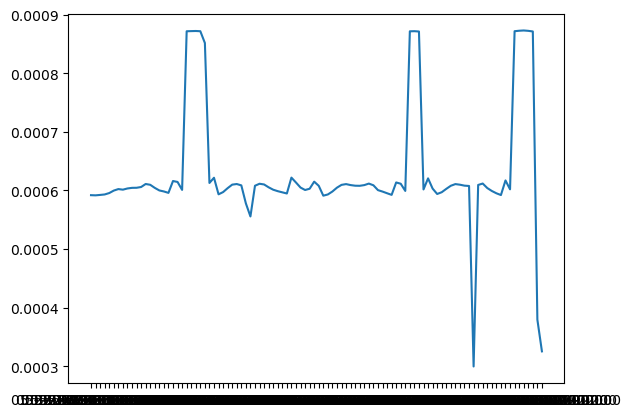

In [82]:
plt.plot(dfs_out[executions[i]].sum(axis=1)[s:e] -dfs_out[executions[j]].sum(axis=1)[s:e] )


In [132]:
predictions[k][predictions[k]<0]

tensor([-1.6770e-03, -1.6655e-03, -1.4092e-03, -8.5970e-04, -8.3087e-04,
        -1.4771e-03, -1.8421e-03, -1.9119e-03, -1.7521e-03, -1.2126e-03,
        -3.6607e-05, -3.5210e-05, -1.2720e-03, -1.9809e-03, -2.2168e-03,
        -2.4916e-03, -2.3611e-03, -1.8751e-03, -6.2423e-04, -9.4098e-04,
        -1.7392e-03, -1.8939e-03, -2.0178e-03, -1.8670e-03, -1.6664e-03,
        -9.7515e-04, -3.5113e-04, -8.4832e-04, -1.0300e-03, -6.3232e-04,
        -5.4706e-04, -1.4973e-03, -1.9278e-03, -2.1825e-03, -2.3071e-03,
        -2.2103e-03, -1.9255e-03, -1.3589e-03, -3.6319e-04, -4.3300e-04,
        -7.5772e-04, -1.0923e-03, -1.2803e-03, -1.3006e-03, -9.5169e-04,
        -3.6556e-04, -1.5125e-03, -2.0256e-03, -2.1660e-03, -2.1440e-03,
        -1.8801e-03, -1.2121e-03, -2.1712e-04, -2.2290e-04, -2.0105e-05,
        -7.1161e-04, -1.3613e-03, -1.3735e-03, -1.4229e-03, -1.1583e-03,
        -4.8179e-04, -2.9509e-04, -3.7839e-04, -1.2888e-04, -7.4902e-04,
        -1.1696e-03, -1.7717e-03, -1.7446e-03, -1.5